In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

### Drainage of a poroelastic sphere

The isotropic compression of a poroelastic sphere of homogeneous medium is a well known problem. We will compute a numerical solution of the displacement and pressure at every point in the sphere after application of a mechanical load with an initial stress field. 

We will start by defining the mesh. Taking advantage of the problem's radial symmetry, we can reduce the domain to a quarter circle.

563
(563, 2)


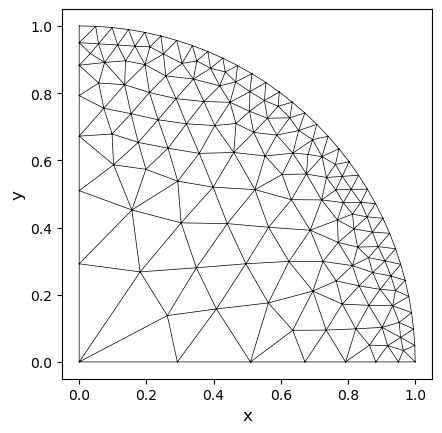

In [2]:
# we define the mesh
r = 1
cell_size = 0.05

import pygmsh
with pygmsh.geo.Geometry() as geom:
    center = geom.add_point([0, 0], 10*cell_size)
    lower_right = geom.add_point([0, r], cell_size)
    upper_left = geom.add_point([r, 0], cell_size)

    bottom = geom.add_line(center, lower_right)
    left = geom.add_line(upper_left, center)
    arc = geom.add_circle_arc(lower_right, center, upper_left)

    loop = geom.add_curve_loop([bottom, arc, left])
    surface = geom.add_plane_surface(loop)
    out = geom.generate_mesh()

mesh = Mesher.Mesh(out, simultype='axis')
mesh = Mesher.tri3_2_tri6(mesh)
mesh.plot()
plt.xlabel('x')
plt.ylabel('y')
print(mesh.nn)
print(mesh.nodes.shape)


In [3]:
"""from scipy.io import loadmat
import os
matmesh = loadmat('../../mesh.mat')
mesh.nodes = matmesh['nodes']
mesh.connectivity = matmesh['connectivity'] - 1
mesh.nn = len(mesh.nodes)
mesh.ne = len(mesh.connectivity)

mesh.plot()"""

"from scipy.io import loadmat\nimport os\nmatmesh = loadmat('../../mesh.mat')\nmesh.nodes = matmesh['nodes']\nmesh.connectivity = matmesh['connectivity'] - 1\nmesh.nn = len(mesh.nodes)\nmesh.ne = len(mesh.connectivity)\n\nmesh.plot()"

In [4]:
# geomechanical parameters
k = 8.4e3  # elastic drained bulk modulus [MPa]
g = 6.8e3  # shear modulus [MPa]
b = 0.707692  # biot coefficient
M = 9.18478e3  # biot modulus [MPa]
k_u = k + M*b**2
perm = 0.137549e-3  # permeability
B = (k_u - k) / (b * k_u)
mu_f = 1  # fluid viscosity
rho = 1  # density
kappa = perm / mu_f  # conductivity
nu_u = prop.poisson_ratio(g, k_u)  # undrained poisson ratio
E_u = prop.young_modulus(g, k_u)  # undrained yougn modulus
nu = prop.poisson_ratio(g, k)  # poisson ratio
E = prop.young_modulus(g, k)  # young modulus
eta = b * (1 - 2 * nu_u) / (2 * (1 - nu_u))  # idk what this is

### Boundary conditions

The axissymmetry tells us that no horizontal ($x$) and vertical ($y$) displacements should be measured around the vertical and horizontal boundaries respectively. We will also set a stress field at the quarter circle's outer edge. 

You then need to find the nodes for those different boundaries.

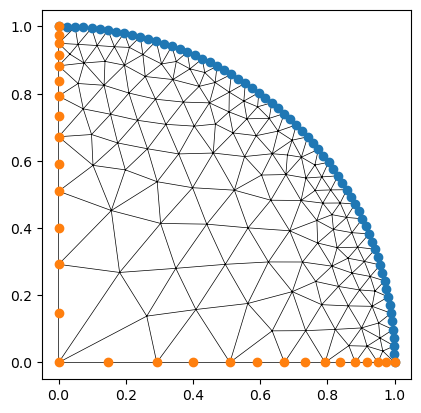

In [5]:
# boundary conditions
bottom = np.argwhere(mesh.nodes[:, 1] == 0)
left = np.argwhere(mesh.nodes[:, 0] < 1e-3)

fixed_dofx = left * 2
fixed_dofy = bottom * 2 + 1

fixed_nodes = np.unique((left, bottom))
fixed_dof = np.unique((fixed_dofx, fixed_dofy))

radius = np.linalg.norm(mesh.nodes, axis=1)
circle = np.argwhere(np.abs(radius - r) <= 1e-3)

mesh.plot()
plt.scatter(*mesh.nodes[circle].T, zorder=10)
plt.scatter(*mesh.nodes[fixed_nodes].T, zorder=10)

### Defining an initial stress field

According the course notes, the stress vector in axissymmetry is defined as

$$ \sigma = \left(\sigma_{rr}\ \sigma_{zz}\ \tau_{rz}\ \sigma_{\theta \theta}\right)^\intercal.$$

We will define an isotropic stress field of unity with the ``set_stress_field`` function. This outputs a vector of length ``2 * mesh.nn``, giving the x and y stress for every node. 

(1126,)
(2, 563)


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x14b0c5a0f10>)

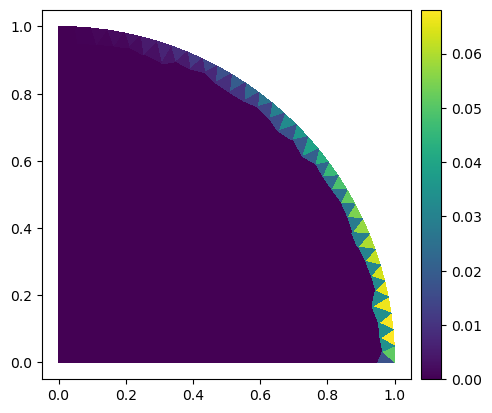

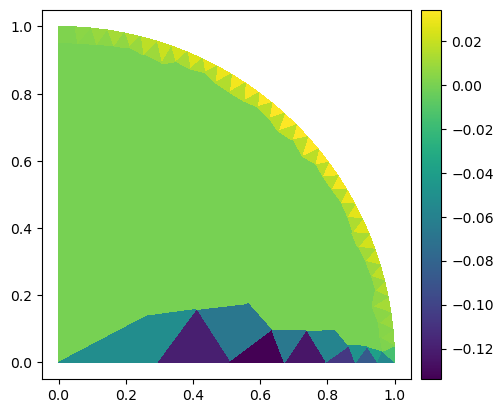

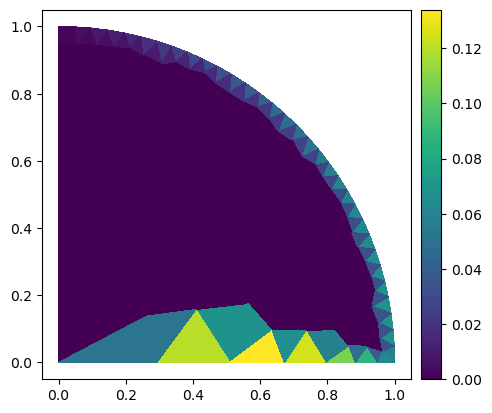

In [6]:
# initial stress field
sig_unif = [-1, -1, 0, -1]
sigma0 = Matrix.set_stress_field(mesh, sig_unif)
print(sigma0.shape)

# let's see what the initial field looks like
# we can reshape the sigma0 vector to a shape (2, mesh.nn)
s0 = sigma0.reshape(2, -1, order='F')
print(s0.shape)
mesh.plot(s0[0], c='none', shading='flat')
mesh.plot(s0[1], c='none', shading='flat')
mesh.plot(np.linalg.norm(s0, axis=0), c='gray', shading='flat')

### Matrix assembly
In the previous exercises, we have coded up the conductivity matrix $\mathbf{C}$, the mass matric $\mathbf{M}$ and the stiffness matrix $\mathbf{K}$. Now, to fully couple porous flow and elasticity, we need to assemble the *coupling* matrix $\mathbf{A}$.

In [7]:
# assembling the different matrices
K = Matrix.assemble_stiffness_matrix(mesh, E, nu)
Mass = Matrix.assemble_mass_matrix(mesh, 1/M)
C = Matrix.assemble_conductivity_matrix(mesh, kappa)

# you need to program this function!
Ce = Matrix.assemble_coupling_matrix(mesh, b)

c:\e2020\civil423\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Undrained conditions

The solution at $t=0$ corresponds to the undrained conditions. We will need to assemble the total matrix $\mathbf{T}$, containing the previously defined matrices. At this step, the pressure is not fixed.

In [8]:
# we can now solve the undrained case
dt = 0
AA = -Mass - dt *C

ntot_E = mesh.nn * 2
ntot_P = mesh.nn
ntot = ntot_E + ntot_P

T = csc_matrix((ntot, ntot))
T[:ntot_E, :ntot_E] = K
T[ntot_E:, :ntot_E] = -Ce.T
T[:ntot_E, ntot_E:] = -Ce
T[ntot_E:, ntot_E:] = AA

ftot = csc_matrix((ntot, 1))
ftot[:ntot_E] = sigma0

eq_free_disp = np.setdiff1d(np.arange(ntot_E), fixed_dof)
eq_free_p = np.arange(ntot_P) + ntot_E
eq_free = np.hstack((eq_free_disp, eq_free_p))


c:\e2020\civil423\Lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\e2020\civil423\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
# solving the system
undrained_sol = csc_matrix((ntot, 1))
undrained_sol[eq_free] = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])

# undrained sol as shape (2 * mesh.nn + mesh.nn, 1), corresponding to the x and y displacements and the pressure.
# we can reshape this vector to access the pressure and displaements easily
pressure_undrained = undrained_sol[ntot_E:].toarray()[:, 0]
disp_undrained = undrained_sol[:ntot_E].toarray().reshape(2, -1, order='F')

Text(0.0, 1.0, 'displacement (m) (1000 x exaggeration) ')

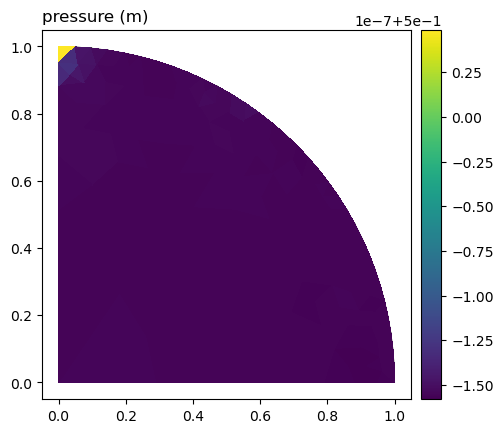

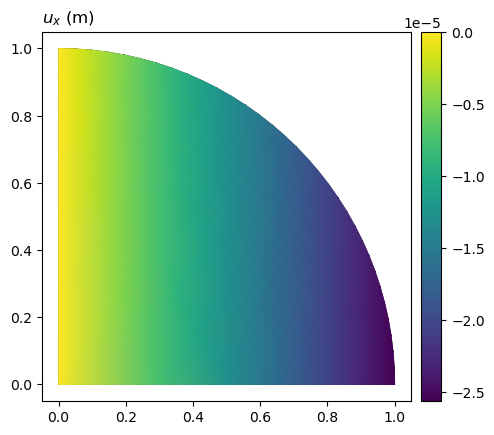

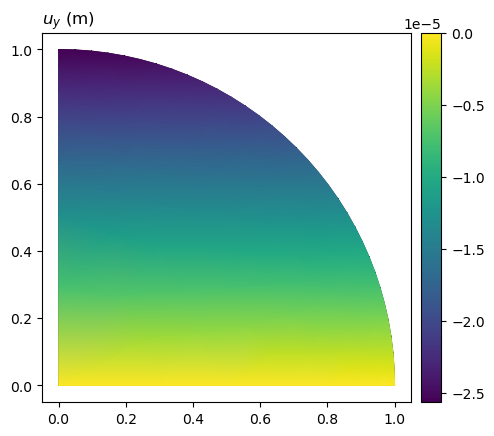

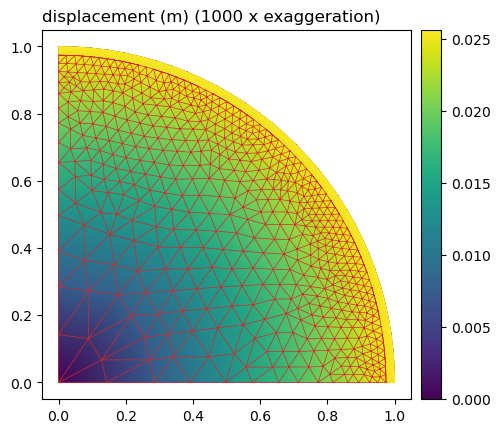

In [10]:
%matplotlib inline
fig, ax, cb = mesh.plot(pressure_undrained, shading='flat')
ax.set_title('pressure (m)', loc='left')

fig, ax, cb = mesh.plot(disp_undrained[0])
ax.set_title('$u_x$ (m)', loc='left')

fig, ax, cb = mesh.plot(disp_undrained[1])
ax.set_title('$u_y$ (m)', loc='left')

factor = 1000
fig, ax, cb = mesh.plot(factor * np.linalg.norm(disp_undrained, axis=0), c='k')
ax.triplot(*(mesh.nodes.T + factor * disp_undrained), c='tab:red', lw=0.5)
#ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], disp_undrained[0], disp_undrained[1])
ax.set_title(f'displacement (m) ({factor} x exaggeration) ', loc='left')

### Solving the system at every time step

Using a constant time stpe, we can now:

- assemble a total matrix where $\Delta t$ is not zero and
- set the pressure at the outer boundary to be fixed at zero.

We will use the previously seen scheme to solve the time derivatives between $t=0$ and $t=1$.

In [11]:
dt = 0.002
t = np.arange(0, 1, dt)

T[ntot_E:, ntot_E:] = -(Mass + dt * C)
pressure = np.zeros((len(t), mesh.nn))
displacement = np.zeros((len(t), 2, mesh.nn))

sol = undrained_sol.copy().toarray()[:, 0]
sol[circle + ntot_E] = 0

eq_free_disp = np.setdiff1d(np.arange(ntot_E), fixed_dof)
eq_free_p = np.setdiff1d(np.arange(ntot_P), circle) + ntot_E
eq_free = np.hstack((eq_free_disp, eq_free_p))

p = np.zeros(ntot)
for i in range(len(t)):
    print(f'\riteration {i+1} out of {len(t)}', end='')

    # the change in flux is adjusted
    p[eq_free_p] = dt * C[eq_free_p - ntot_E].dot(sol[ntot_E:])

    # we can solve the system
    update = linalg.spsolve(T[eq_free][:, eq_free], p[eq_free])
    sol[eq_free] = sol[eq_free] + update

    pressure[i] = sol[ntot_E:]
    displacement[i] = sol[:ntot_E].reshape(2, -1, order='F')

iteration 500 out of 500

### Comparison with an analytical solution
The analytical solution is contained in the file ``PP-Sphere-ohio.csv`` and shows the pressure at the center of our poroelastic sphere. We will need to extract the nodes at this location. We can also look at the displacements at the outer boundary of the sphere (and only one point is needed because of the symmetry).

In [17]:
top = np.argwhere((mesh.nodes[:, 0] <= 1e-3) & (np.abs(mesh.nodes[:, 1] - r) <= 1e-3))[:, 0]
center = np.argwhere((mesh.nodes[:, 0] <= 1e-3) & (mesh.nodes[:, 1] <= 1e-3))[:, 0]
right = np.argwhere((mesh.nodes[:, 1] <= 1e-3) & (np.abs(mesh.nodes[:, 0] - r) <= 1e-3))[:, 0]

mesh.plot()
plt.scatter(*mesh.nodes[top].T)
plt.scatter(*mesh.nodes[right].T)
plt.scatter(*mesh.nodes[center].T)


(-0.05, 1.0)

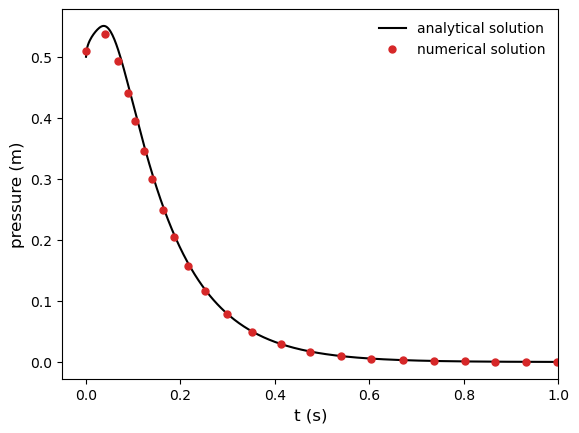

In [13]:
%matplotlib inline
analt, analp = np.loadtxt('PP-Sphere-ohio.csv', delimiter=',').T
plt.plot(analt, analp, label='analytical solution', c='k')
plt.plot(t, pressure[:, center], lw=0, marker='.', ms=10, markevery=0.05, label='numerical solution', c='tab:red')
plt.legend(frameon=False)
plt.xlabel('t (s)')
plt.ylabel('pressure (m)')
plt.xlim(-0.05, 1)


In [18]:
# we can also look at the displacementes at the boundary
# however here we have no analytical solution to compare with
norm = np.linalg.norm(displacement, axis=1)
plt.plot(t, norm[:, top])
plt.plot(t, norm[:, right])

plt.xlabel('t (s)')
plt.ylabel('displacement (m)')

Text(0, 0.5, 'displacement (m)')

In [15]:
%matplotlib qt
# we can animate it

from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pressure[0], lw=1, shading='gouraud')
plt.colorbar(im)
mesh.plot(ax=ax, c='gray')
ax.set_aspect(1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
time = ax.set_title('t=0')

def update(i):
    time.set_text(f't={t[i]:.2f}')
    im.set_array(pressure[i])
    return im, time

ani = FuncAnimation(fig, update, frames=int(len(t)/2), interval=5)
